In [9]:
import os
import typing

from sklearn.gaussian_process.kernels import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import cm

# SHA
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import time
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import seaborn as sns


In [2]:
# Cost function constants
THRESHOLD = 35.5
COST_W_NORMAL = 1.0
COST_W_OVERPREDICT = 5.0
COST_W_THRESHOLD = 20.0

In [97]:
def cost_function(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    """
    Calculates the cost of a set of predictions.

    :param y_true: Ground truth pollution levels as a 1d NumPy float array
    :param y_predicted: Predicted pollution levels as a 1d NumPy float array
    :return: Total cost of all predictions as a single float
    """
    assert y_true.ndim == 1 and y_predicted.ndim == 1 and y_true.shape == y_predicted.shape

    # Unweighted cost
    cost = (y_true - y_predicted) ** 2
    weights = np.zeros_like(cost)

    # Case i): overprediction
    mask_1 = y_predicted > y_true
    weights[mask_1] = COST_W_OVERPREDICT

    # Case ii): true is above threshold, prediction below
    mask_2 = (y_true >= THRESHOLD) & (y_predicted < THRESHOLD)
    weights[mask_2] = COST_W_THRESHOLD

    # Case iii): everything else
    mask_3 = ~(mask_1 | mask_2)
    weights[mask_3] = COST_W_NORMAL

    print(f"1) overprediction - cost is {np.mean(cost[mask_1])} - contributes {np.mean(cost[mask_1])*COST_W_OVERPREDICT}")
    print(f"2) true is above threshold, prediction below - cost is {np.mean(cost[mask_2])} - contributes {np.mean(cost[mask_2])*COST_W_THRESHOLD}")
    print(f"3) overprediction cost is {np.mean(cost[mask_3])} - contributes {np.mean(cost[mask_3])*COST_W_NORMAL}")

    # Weigh the cost and return the average
    return np.mean(cost * weights)

In [52]:
# Import Data

train_x = np.loadtxt('train_x.csv', delimiter=',', skiprows=1)
train_y = np.loadtxt('train_y.csv', delimiter=',', skiprows=1)
test_x = np.loadtxt('test_x.csv', delimiter=',', skiprows=1)

print(train_x.shape)
print(train_y.shape)

(15189, 2)
(15189,)


185
(185,)
(185,)
(185,)


[]

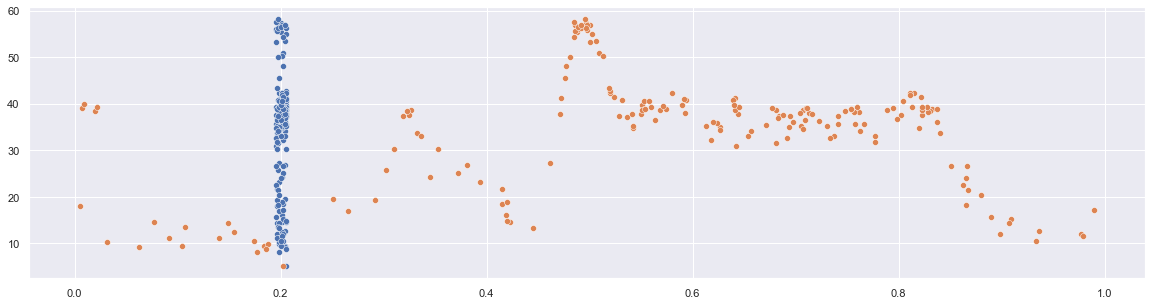

In [165]:
sns.set(rc={'figure.figsize':(20,5)})

slice_axis = 1
slice_mean = 0.2
slice_range = 0.005

ind = np.where(np.logical_and(train_x[:, slice_axis]>=slice_mean-slice_range, train_x[:, slice_axis]<=slice_mean+slice_range))
print(len(ind[0]))

train_x_slice_side = train_x[ind[0], slice_axis]
print(train_x_slice_side.shape)
train_x_slice_front = train_x[ind[0], 1-slice_axis]
print(train_x_slice_front.shape)

train_y_slice = train_y[ind]
print(train_y_slice.shape)

sns.scatterplot(x=train_x_slice_side.squeeze(), y=train_y_slice).plot()
sns.scatterplot(x=train_x_slice_front.squeeze(), y=train_y_slice).plot()


-2937611463.3022094
{'length_scale': 0.02, 'length_scale_bounds': 'fixed', 'nu': 1.5}
1) overprediction - cost is 0.45226415639929757 - contributes 2.261320781996488
2) true is above threshold, prediction below - cost is 12.808180803417944 - contributes 256.16361606835886
3) overprediction cost is 0.40306437831978825 - contributes 0.40306437831978825
Average Error is 2.810106026239045


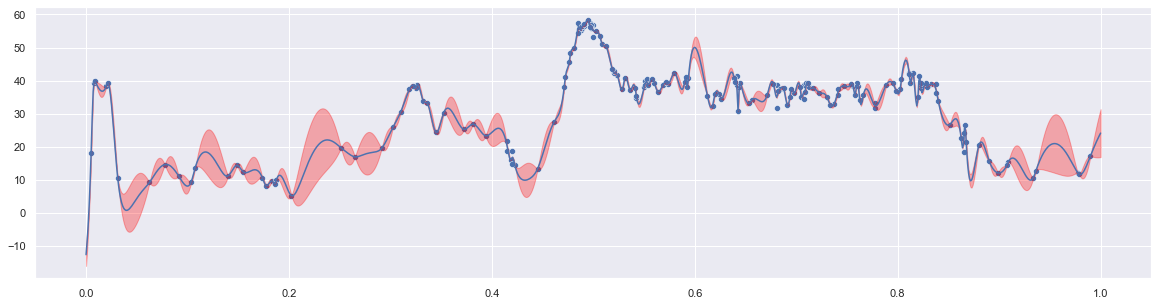

In [171]:
# Model Slice

#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.01, (1e-3, 1e0))
#kernel = 1 * RBF(0.01, (1e-5, 1e5))
#kernel = RBF()
#kernel = Matern(length_scale=0.0253, length_scale_bounds="fixed", nu=1.5) 
#kernel = Matern(length_scale=0.0297, length_scale_bounds="fixed", nu=1.5) 
#kernel = RBF(length_scale=0.0253, length_scale_bounds="fixed") #+ WhiteKernel(1e-5)
#kernel = Matern(length_scale=0.0253, length_scale_bounds="fixed", nu=1.5) \
#+ WhiteKernel(1e-2, noise_level_bounds="fixed")
# kernel = Matern(length_scale=0.297, length_scale_bounds="fixed", nu=1.5) + WhiteKernel(1e-2, noise_level_bounds="fixed")
kernel = Matern(length_scale=0.02, length_scale_bounds="fixed", nu=1.5)


model = GaussianProcessRegressor(kernel, normalize_y=True, n_restarts_optimizer=100, random_state=42)#, alpha=0.1)

model.fit(train_x_slice_front[:, np.newaxis], train_y_slice)

print(model.log_marginal_likelihood(model.kernel_.theta))
# print(model.get_params())
print(model.kernel_.get_params(deep=True))

X_plot = np.linspace(0, 1, 1000)
y_mean, y_std = model.predict(X_plot[:, None], return_std=True)

sns.scatterplot(x=train_x_slice_front.squeeze(), y=train_y_slice).plot()
ax = sns.lineplot(x=X_plot, y=y_mean)

ax.fill_between(X_plot, y_mean-y_std, y_mean+y_std, color="red", alpha=0.3)


y_mean, y_std = model.predict(train_x_slice_front[:, np.newaxis], return_std=True)

error = cost_function(train_y_slice, y_mean)
print(f"Average Error is {error}")



<AxesSubplot:ylabel='Count'>

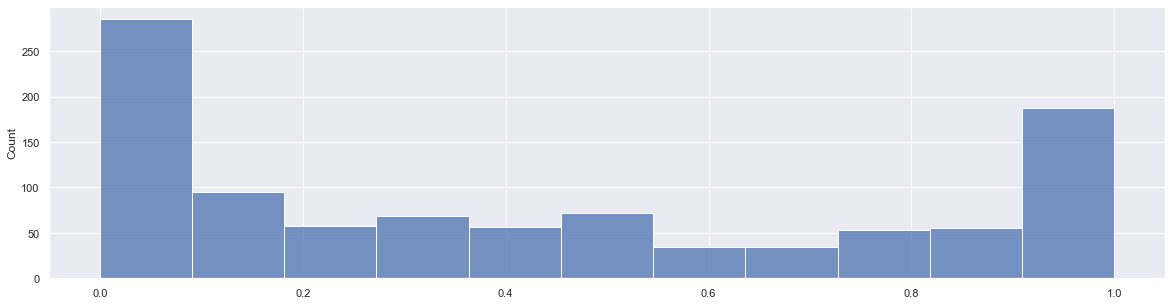

In [91]:
sns.histplot(y_std)

In [51]:
# Prepare train test split

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.9, random_state=42)

print(X_train.shape, X_test.shape)

(1518, 2) (13671, 2)


In [71]:
# Plot data
%matplotlib widget

fig = plt.figure(1)
ax = plt.axes(projection='3d')
ax.set_box_aspect(aspect = (10,10,1))
ax.scatter3D(train_x[:,0], train_x[:,1], train_y[:, np.newaxis], s=0.5, c=train_y, cmap='viridis')
fig.show()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [52]:
# Fit Model

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.01, (1e-3, 1e0))
model = GaussianProcessRegressor(kernel, normalize_y=True)

model.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.01), normalize_y=True)

In [83]:
print(model.log_marginal_likelihood())
print(model.get_params())
print(model.kernel_.get_params(deep=True))

-1600.5764550114982
{'alpha': 1e-10, 'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=0.01), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (0.001, 1000.0), 'kernel__k2__length_scale': 0.01, 'kernel__k2__length_scale_bounds': (0.001, 1.0), 'kernel': 1**2 * RBF(length_scale=0.01), 'n_restarts_optimizer': 0, 'normalize_y': True, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None}
{'k1': 0.886**2, 'k2': RBF(length_scale=0.00848), 'k1__constant_value': 0.7850213018296704, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale': 0.00848370922362822, 'k2__length_scale_bounds': (0.001, 1.0)}


In [62]:
# Predict

gp_mean, gp_std = model.predict(X_test, return_std=True)

# prediction = gp_mean # 668.2831708428682
# prediction = gp_mean + gp_std * norm.ppf(1/6) # 2240.5252997911316

# prediction = np.where(gp_mean + gp_std * norm.ppf(20/21) >= THRESHOLD, 
#     gp_mean + gp_std * norm.ppf(20/21), 
#     gp_mean + gp_std * norm.ppf(1/5)
# )

prediction = np.where(gp_mean >= 35.5 - 2 * gp_std,
                               gp_mean + gp_std * norm.ppf(20/25),
                               gp_mean + gp_std * norm.ppf(1/6))

cost_function(y_test, prediction)


1790.7116792174086

In [58]:
norm.ppf(20/21)

1.668391193947079

In [76]:
import seaborn as sns
#sns.displot(gp_std, bins=82, kde=True)
sns.displot(gp_mean, bins=82, kde=True)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …